In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv('./train-balanced-sarcasm.csv.zip')

In [4]:
df.head()

,label,comment,score
0,1,This can't possibly go wrong.,29
1,1,I agree with the government...It would be MUCH...,2
2,0,There is just not enough people around that un...,1
3,1,"This, dear sirs and madams, is why we need fem...",1
4,0,13 actually has a nice algorithm that works si...,4


In [5]:
df = df[df.score>10]

In [ ]:
df = df[['label','comment']].copy()
df.comment = df.comment.astype('str')

In [7]:
df_train, df_test = train_test_split(df, test_size=0.2)

In [8]:
tok = tf.keras.preprocessing.text.Tokenizer(num_words=10000, lower=True)
tok.fit_on_texts(df_train.comment)

In [9]:
df_train.label = df_train.label.astype('int32')
df_test.label = df_test.label.astype('int32')
df_train.loc[:,'comment'] = tok.texts_to_sequences(df_train.comment)
df_test.loc[:,'comment'] = tok.texts_to_sequences(df_test.comment)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3162: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


In [10]:
df_train.head()

,label,comment
229817,1,"[31, 31, 11, 26, 1, 1602, 5, 87]"
364395,1,"[1660, 8, 2898]"
71101,0,"[22, 334, 71, 972, 21, 10, 11, 84]"
381083,0,"[2899, 6395, 66, 584, 4, 477, 120, 3464, 12, 1..."
293408,1,"[169, 16, 44, 1603, 11, 24, 2, 6396, 3073, 216..."


In [11]:
N_train = df_train.comment.apply(len)
N_test = df_test.comment.apply(len)

In [12]:
df_train = df_train.loc[(10<=N_train)&(N_train<=100)]
df_test = df_test.loc[(10<=N_test)&(N_test<=100)]

In [13]:
df_train.head()

,label,comment
381083,0,"[2899, 6395, 66, 584, 4, 477, 120, 3464, 12, 1..."
293408,1,"[169, 16, 44, 1603, 11, 24, 2, 6396, 3073, 216..."
163338,1,"[41, 1, 4301, 39, 20, 106, 110, 105, 130, 24, ..."
94182,1,"[29, 51, 317, 2767, 644, 131, 2, 631, 8, 244, ..."
117687,1,"[41, 25, 21, 27, 182, 2, 3702, 6, 420, 1015, 2..."


Now, we will have to pad the data. Since, we are working with hundreds of thousands of sentences. Padding the entire dataset is wasteful.

We can do it online by using TensorFlow dataset. This enables us to do operations online, such as padding, shuffling, among other.

Note that we are defining here the batch size and then padding the batch.

The prefetch operation will decouple the preparation of the batch with the execution itself. Removing the waiting time of the network for more data.

In [14]:
ragged_train = tf.ragged.constant(df_train.comment)
label_train = df_train.label
data_test = df_test.comment
label_test = df_test.label

In [15]:
dataset_train = tf.data.Dataset.from_tensor_slices((ragged_train,label_train))
dataset_train = dataset_train.shuffle(5000)
dataset_train = dataset_train.batch(512)
dataset_train = dataset_train.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=5)
dataset_train = dataset_train.prefetch(3)

In [16]:
ragged_test = tf.ragged.constant(data_test)
label_test = tf.ragged.constant(label_test)
dataset_test = tf.data.Dataset.from_tensor_slices((ragged_test,label_test))
dataset_test = dataset_test.batch(512)
dataset_test = dataset_test.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y), num_parallel_calls=5)
dataset_test = dataset_test.prefetch(3)

Now, we can define the model based on LSTMs. 

From the google [Translate paper](https://arxiv.org/abs/1609.08144), we can see that skip connections enable us to train deeper recurrent networks.

For that, add skips connections between different LSTMs layers.

In [18]:
emb_size = 128
hidden_size = 12

In [19]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=[None,], dtype=tf.int32)
word_emb = tf.keras.layers.Embedding(tok.num_words+1, emb_size, mask_zero=True)(inputs)
LSTM1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h1  = LSTM1(word_emb)
proyection_W = tf.keras.layers.Dense(LSTM1.units, name='Res_W', activation='relu')
residual1 = h1 + proyection_W(word_emb)
LSTM2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h2 = LSTM2(residual1)
residual2 = h2 + h1

LSTM3 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h3 = LSTM3(residual2)

residual3 = h3 + h2

LSTM4 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
h4 = LSTM4(residual3)

h = tf.keras.layers.Concatenate(axis=2)([h1, h2, h3, h4])
final = tf.keras.layers.LSTM(hidden_size, return_sequences=False)(h)

output = tf.keras.layers.Dense(2, activation='softmax')(final)

model = tf.keras.Model(inputs = inputs, outputs = output)

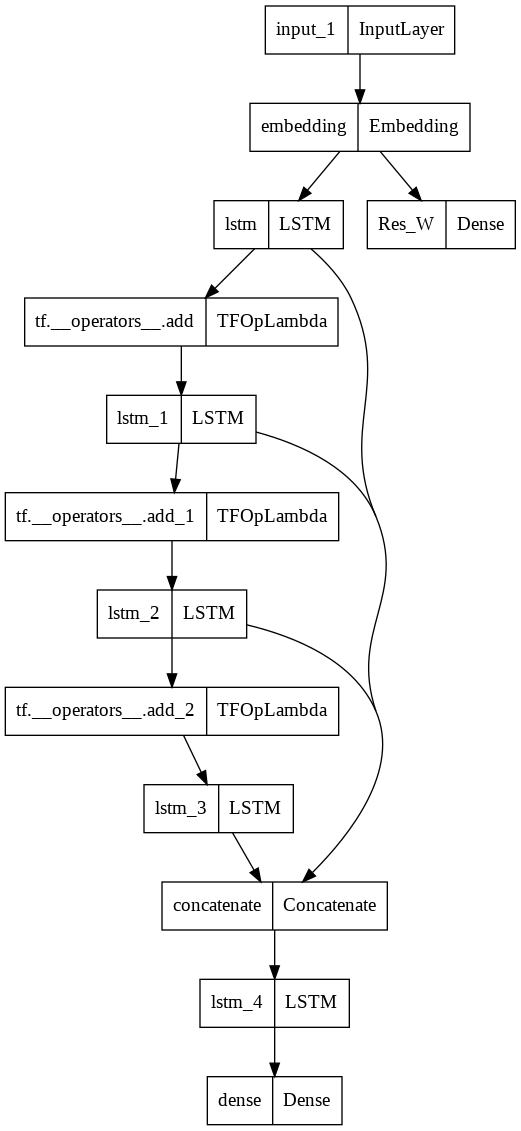

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(model)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 128)    1280128     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, None, 12)     6768        ['embedding[0][0]']              
                                                                                                  
 Res_W (Dense)                  (None, None, 12)     1548        ['embedding[0][0]']              
                                                                                              

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [23]:
history = model.fit(dataset_train, epochs =20, validation_data=dataset_test)

Epoch 1/20
42/42 [==============================] - 33s 488ms/step - loss: 0.6134 - accuracy: 0.6609 - val_loss: 0.5776 - val_accuracy: 0.6897
Epoch 2/20
42/42 [==============================] - 17s 403ms/step - loss: 0.4805 - accuracy: 0.7763 - val_loss: 0.6395 - val_accuracy: 0.6836
Epoch 3/20
42/42 [==============================] - 18s 431ms/step - loss: 0.3814 - accuracy: 0.8327 - val_loss: 0.6811 - val_accuracy: 0.6647
Epoch 4/20
42/42 [==============================] - 17s 405ms/step - loss: 0.2761 - accuracy: 0.8855 - val_loss: 0.8943 - val_accuracy: 0.6509
Epoch 5/20
42/42 [==============================] - 16s 385ms/step - loss: 0.1988 - accuracy: 0.9194 - val_loss: 1.1439 - val_accuracy: 0.6413
Epoch 6/20
42/42 [==============================] - 17s 396ms/step - loss: 0.1473 - accuracy: 0.9418 - val_loss: 1.2726 - val_accuracy: 0.6461
Epoch 7/20
42/42 [==============================] - 17s 402ms/step - loss: 0.0981 - accuracy: 0.9643 - val_loss: 1.4847 - val_accuracy: 0.6440

In [24]:
pred = model.predict(dataset_test)
pred = pred.argmax(axis=1)

In [25]:
print(classification_report(label_test, pred))

              precision    recall  f1-score   support

           0       0.60      0.59      0.59      2262
           1       0.69      0.69      0.69      2937

    accuracy                           0.65      5199
   macro avg       0.64      0.64      0.64      5199
weighted avg       0.65      0.65      0.65      5199



Now you have a model to detect sarcasm. Use it with your own sentences. 
How are your predictions?

In [27]:
model.predict(tok.texts_to_sequences(['Could this model be any worse?']))

array([[0.6725572 , 0.32744277]], dtype=float32)